# PageRank Performance Benchmarking

This notebook benchmarks performance improvement of running PageRank within cuGraph against NetworkX.

Notebook Credits

    Original Authors: Bradley Rees
    Last Edit: 09/18/2019
        - added NetworkX pagerank_scipy

RAPIDS Versions: 0.10.0

Test Hardware

    GV100 32G, CUDA 10.1
    Intel(R) Xeon(R) CPU E5-2643 v4 @ 3.40GHz
    64GB system memory
    
   

In [1]:
!nvidia-smi

Wed Sep 18 16:14:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:04:00.0  On |                  Off |
| 40%   53C    P0    48W / 250W |    526MiB / 32455MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro GV100        Off  | 00000000:84:00.0 Off |                  Off |
| 36%   49C    P2    41W / 250W |      1MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
! head /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU E5-2643 v4 @ 3.40GHz
stepping	: 1
microcode	: 0xb000036
cpu MHz		: 1212.171
cache size	: 20480 KB
physical id	: 0


In [3]:
# Import needed libraries
import time
import cugraph
import cudf
import numpy as np
from collections import OrderedDict

In [4]:
# NetworkX libraries
import networkx as nx
from scipy.io import mmread

### Define the test data

In [5]:
# Test File
data = {
    'preferentialAttachment' : './data/preferentialAttachment.mtx',
    'caidaRouterLevel'       : './data/caidaRouterLevel.mtx',
    'coAuthorsDBLP'          : './data/coAuthorsDBLP.mtx',
    'dblp'                   : './data/dblp-2010.mtx',
    'citationCiteseer'       : './data/citationCiteseer.mtx',
    'coPapersDBLP'           : './data/coPapersDBLP.mtx',
    'coPapersCiteseer'       : './data/coPapersCiteseer.mtx',
    'as-Skitter'             : './data/as-Skitter.mtx'
}

### Define the testing functions

In [6]:
def read_mtx_file(mm_file):
    print('Reading ' + str(mm_file) + '...')
    M = mmread(mm_file).asfptype()
     
    return M

In [7]:
def cugraph_call(M, max_iter, tol, alpha):
    # Device data
    sources = cudf.Series(M.row)
    destinations = cudf.Series(M.col)

    # cugraph Pagerank Call
    G = cugraph.Graph()
    G.add_edge_list(sources, destinations, None)
    
    t1 = time.time()
    df = cugraph.pagerank(G, alpha=alpha, max_iter=max_iter, tol=tol)
    t2 = time.time() - t1
    
    return t2
    

In [8]:
def networkx_call(M, max_iter, tol, alpha):
    nnz_per_row = {r: 0 for r in range(M.get_shape()[0])}
    for nnz in range(M.getnnz()):
        nnz_per_row[M.row[nnz]] = 1 + nnz_per_row[M.row[nnz]]
    for nnz in range(M.getnnz()):
        M.data[nnz] = 1.0/float(nnz_per_row[M.row[nnz]])

    M = M.tocsr()
    if M is None:
        raise TypeError('Could not read the input graph')
    if M.shape[0] != M.shape[1]:
        raise TypeError('Shape is not square')

    # should be autosorted, but check just to make sure
    if not M.has_sorted_indices:
        print('sort_indices ... ')
        M.sort_indices()

    # Directed NetworkX graph
    Gnx = nx.DiGraph(M)

    z = {k: 1.0/M.shape[0] for k in range(M.shape[0])}

    # Networkx Pagerank Call
    print('Solving... ')
    t1 = time.time()
    pr = nx.pagerank(Gnx, alpha, z, max_iter, tol)
    t2 = time.time() - t1

    return t2

In [9]:
def networkx_scipy_call(M, max_iter, tol, alpha):
    nnz_per_row = {r: 0 for r in range(M.get_shape()[0])}
    for nnz in range(M.getnnz()):
        nnz_per_row[M.row[nnz]] = 1 + nnz_per_row[M.row[nnz]]
    for nnz in range(M.getnnz()):
        M.data[nnz] = 1.0/float(nnz_per_row[M.row[nnz]])

    M = M.tocsr()
    if M is None:
        raise TypeError('Could not read the input graph')
    if M.shape[0] != M.shape[1]:
        raise TypeError('Shape is not square')

    # should be autosorted, but check just to make sure
    if not M.has_sorted_indices:
        print('sort_indices ... ')
        M.sort_indices()

    # Directed NetworkX graph
    Gnx = nx.DiGraph(M)

    z = {k: 1.0/M.shape[0] for k in range(M.shape[0])}

    # Networkx Pagerank Call
    print('Solving... ')
    t1 = time.time()
    pr = nx.pagerank_scipy(Gnx, alpha, z, max_iter, tol)
    t2 = time.time() - t1

    return t2

### Run the benchmarks

In [10]:
perf_nx = []
perf_sp = []
names = []

for k,v in data.items():
    # capture the file name
    names.append(k)
    
    M = read_mtx_file(v)
    trapids = cugraph_call(M, 100, 0.00001, 0.85)
    tn = networkx_call(M, 100, 0.00001, 0.85)
    speedUp = (tn / trapids)
    perf_nx.append(speedUp)
    print(str(speedUp) + "x faster =>  cugraph " + str(trapids) + " vs " + str(tn))
    
    tsp = networkx_scipy_call(M, 100, 0.00001, 0.85)
    speedUp = (tsp / trapids)
    perf_sp.append(speedUp)  
    
    print(str(speedUp) + "x faster =>  cugraph " + str(trapids) + " vs " + str(tsp))

Reading ./data/preferentialAttachment.mtx...
Solving... 
364.88122014792077x faster =>  cugraph 0.03603982925415039 vs 13.150256872177124
Solving... 
177.29639062727406x faster =>  cugraph 0.03603982925415039 vs 6.3897316455841064
Reading ./data/caidaRouterLevel.mtx...
Solving... 
245.10296080757286x faster =>  cugraph 0.07054781913757324 vs 17.291479349136353
Solving... 
121.57388500806019x faster =>  cugraph 0.07054781913757324 vs 8.576772451400757
Reading ./data/coAuthorsDBLP.mtx...
Solving... 
569.551331379166x faster =>  cugraph 0.048395395278930664 vs 27.563661813735962
Solving... 
264.0304505259009x faster =>  cugraph 0.048395395278930664 vs 12.777858018875122
Reading ./data/dblp-2010.mtx...
Solving... 
654.8223139341629x faster =>  cugraph 0.03414201736450195 vs 22.35695481300354
Solving... 
270.3595480510049x faster =>  cugraph 0.03414201736450195 vs 9.230620384216309
Reading ./data/citationCiteseer.mtx...
Solving... 
632.5896733157168x faster =>  cugraph 0.050977468490600586 

In [11]:
### plot the output

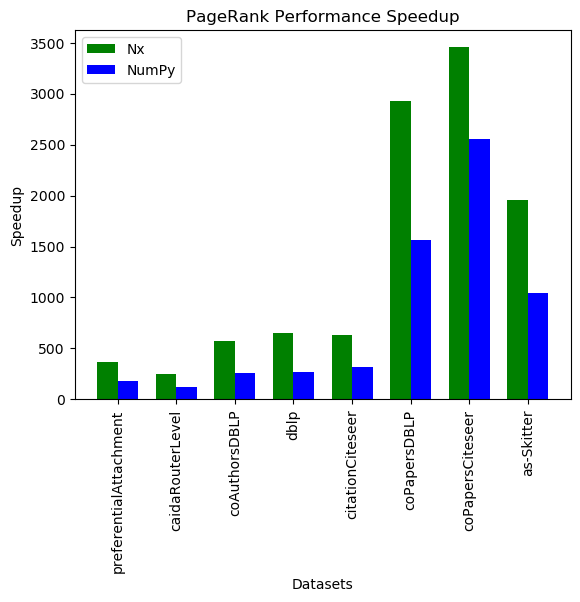

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

bar_width = 0.35
index = np.arange(len(names))

_ = plt.bar(index, perf_nx, bar_width, color='g', label='Nx')
_ = plt.bar(index + bar_width, perf_sp, bar_width, color='b', label='NumPy')


plt.xlabel('Datasets')
plt.ylabel('Speedup')
plt.title('PageRank Performance Speedup')
plt.xticks(index + (bar_width / 2), names)
plt.xticks(rotation=90) 

plt.legend()
plt.show()